In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [30]:
df.columns

Index(['stock_code', 'firm_name', 'year', 'month', 'establishment',
       'prefecture', 'prefecture_code', 'indcode_small', 'indname_small',
       'indcode_large', 'indname_large', 'yj_sales_growth', 'yj_total_assets',
       'yj_operating_cash_flow', 'yj_ros', 'yj_cash_deposit_ratio',
       'yj_leverage', 'yj_stock_price_growth', 'yj_net_profit_growth',
       'yj_firm_age', 'yj_fixed_assets_ratio', 'lag_yj_sales_growth',
       'lag_yj_total_assets', 'lag_yj_operating_cash_flow', 'lag_yj_ros',
       'lag_yj_cash_deposit_ratio', 'lag_yj_leverage',
       'lag_yj_stock_price_growth', 'lag_yj_net_profit_growth',
       'lag_yj_firm_age', 'lag_yj_fixed_assets_ratio', 'earthquake_dummy',
       'lag_earthquake_dummy', 'BCP_obs', 'BCP', 'ps'],
      dtype='object')

In [23]:
# データの読込
path = '../../data/Analysis/analysis_data.csv'
df = pd.read_csv(path, encoding='cp932', header=0)

# 共変量Xを選択
X = df[[
    'lag_yj_total_assets', 'lag_yj_operating_cash_flow', 'lag_yj_ros',
    'lag_yj_cash_deposit_ratio', 'lag_yj_leverage', 'lag_yj_stock_price_growth',
    'lag_yj_firm_age', 'lag_yj_fixed_assets_ratio',
    'lag_earthquake_dummy', 'prefecture_code', 'indcode_small',
    ]]

# 群別変数Zを選択
y = df['BCP']

# 傾向スコアの推定
const = sm.add_constant(X) # 切片の追加
logit_model = sm.Logit(endog=y, exog=const) # ロジスティック回帰
logit_res = logit_model.fit()

ps = logit_res.predict(const)
df['ps'] = ps
print('AUC = {:.3f}'.format(roc_auc_score(y_true=y, y_score=ps)))
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.423249
         Iterations 7
AUC = 0.725


C:\Users\koeci\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    BCP   No. Observations:                28258
Model:                          Logit   Df Residuals:                    28246
Method:                           MLE   Df Model:                           11
Date:                Mon, 18 Oct 2021   Pseudo R-squ.:                  0.1024
Time:                        09:52:26   Log-Likelihood:                -11960.
converged:                       True   LL-Null:                       -13325.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.5809      0.078    -33.281      0.000      -2.733      -2.429
lag_yj_total_assets            0.5130      0.022     23.780      0.000       0.471       0.555
lag_yj_operating_cash_flow    -0.0810      0.016     -4.924      0.000      -0.113      -0.049
lag_yj_ros                    -0.0607      0.019     -3.190      0.001      -0.098      -0.023
lag_yj_cash_deposit_ratio      0.0422      0.020      2.133      0.033       0.003       0.081
lag_yj_leverage               -0.0492      0.023     -2.105      0.035      -0.095      -0.003
lag_yj_stock_price_growth     -0.0237      0.018     -1.351      0.177      -0.058       0.011
lag_yj_firm_age                0.1475      0.018      8.005      0.000       0.111       0.184
lag_yj_fixed_assets_ratio     -0.1980      0.023     -8.499      0.000      -0.244      -0.152
lag_earthquake_dummy           1.6740      0.053     31.873      0.000       1.571       1.777
prefecture_code               -0.0146      0.002     -6.238      0.000      -0.019      -0.010
indcode_small              -2.498e-05   9.84e-06     -2.539      0.011   -4.43e-05    -5.7e-06
==============================================================================================
"""

BCP
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ps, dtype: object

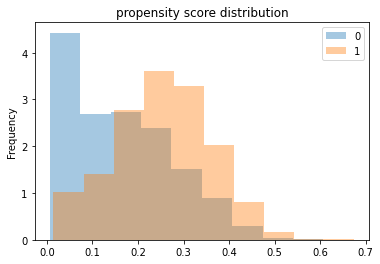

In [24]:
# 傾向スコアの分布を確認
ps_dist = df.groupby('BCP')['ps']
ps_dist.plot.hist(density=True, alpha=0.4, title=f'propensity score distribution', legend=True)

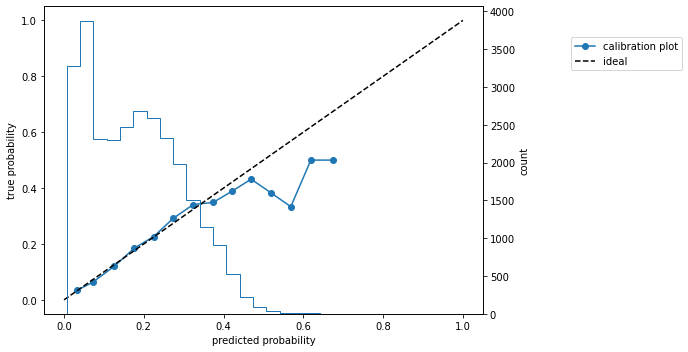

In [25]:
def calibration_plot(y_true, y_prob):
    fig, ax = plt.subplots(figsize=(10, 5))
    prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, n_bins=20)
    ax.plot(prob_pred, prob_true, marker='o', label='calibration plot')
    ax.plot([0,1], [0,1], linestyle='--', color='black', label='ideal')
    ax.legend(bbox_to_anchor=(1.2, 0.9), loc='upper left', borderaxespad=0)
    ax.set_xlabel('predicted probability')
    ax.set_ylabel('true probability')

    ax2 = ax.twinx()
    ax2.hist(y_prob, bins=20, histtype='step', rwidth=0.9)
    ax2.set_ylabel('count')
    plt.tight_layout()
    plt.show()

calibration_plot(y_true=y, y_prob=df['ps'])

### Logistic Regression

0.8180338311274683
[0.08333451 0.08485426 0.0833417  ... 0.2735705  0.27347172 0.27363734]
AUC = 0.719


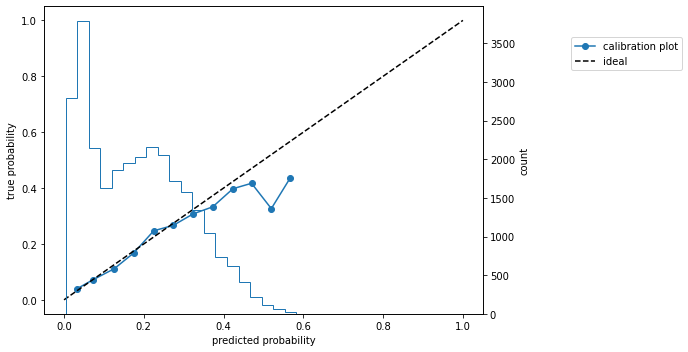

In [26]:
rs = 1234
clf = LogisticRegression(max_iter=1000, random_state=rs)
clf.fit(X, y)
pred = clf.predict_proba(X)[:, 1]
print(clf.score(X, y))
print(pred)
print('AUC = {:.3f}'.format(roc_auc_score(y_true=y, y_score=pred)))
calibration_plot(y_true=y, y_prob=pred)

### Random Forest

0.8728473696626563
[0.2  0.08 0.09 ... 0.14 0.06 0.51]
0.8842887473460722
[0.06741903 0.01937405 0.05075457 ... 0.11809139 0.06036296 0.64063768]
AUC = 0.889


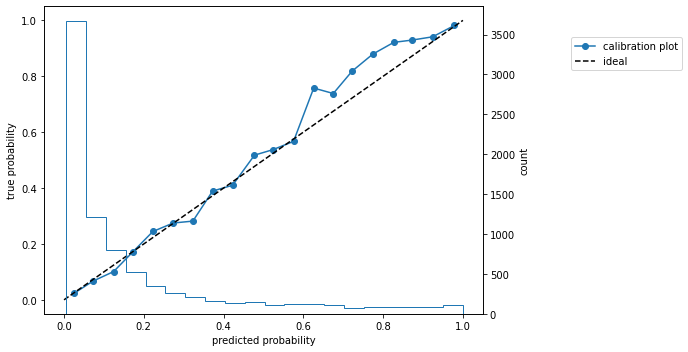

In [27]:
rs = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
clf = RandomForestClassifier(random_state=rs)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]
print(clf.score(X_test, y_test))
print(pred)

# Random Forest: 補正前のcalibration curve
# print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=pred)))
# calibration_plot(y_true=y_test, y_prob=pred)

calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_pred = calibrated_clf.predict_proba(X_test)[:, 1]
print(calibrated_clf.score(X_test, y_test))
print(calibrated_pred)

# Random Forest: 補正後のcalibration curve
print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=calibrated_pred)))
calibration_plot(y_true=y_test, y_prob=calibrated_pred)

### Gradient Boosting (勾配ブースティング)

0.8203585751356453
[0.19531234 0.02220571 0.05771847 ... 0.21564602 0.06870802 0.22942059]
0.8248407643312102
[0.20083253 0.00883063 0.04048608 ... 0.20809061 0.04745848 0.25600893]
AUC = 0.773


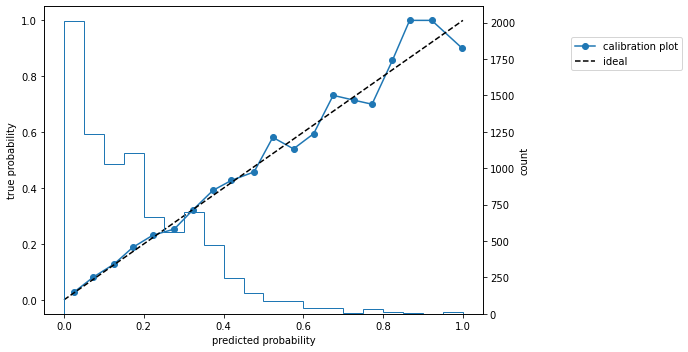

In [28]:
rs = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
clf = GradientBoostingClassifier(random_state=rs)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)[:, 1]
print(clf.score(X_test, y_test))
print(pred)

calibrated_clf = CalibratedClassifierCV(clf, method='isotonic', cv=5)
calibrated_clf.fit(X_train, y_train)
calibrated_pred = calibrated_clf.predict_proba(X_test)[:, 1]
print(calibrated_clf.score(X_test, y_test))
print(calibrated_pred)

# Gradinet Boosting: 補正後のcalibration curve
print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=calibrated_pred)))
calibration_plot(y_true=y_test, y_prob=calibrated_pred)

### LightGBM

0.8510261854210899
AUC = 0.853


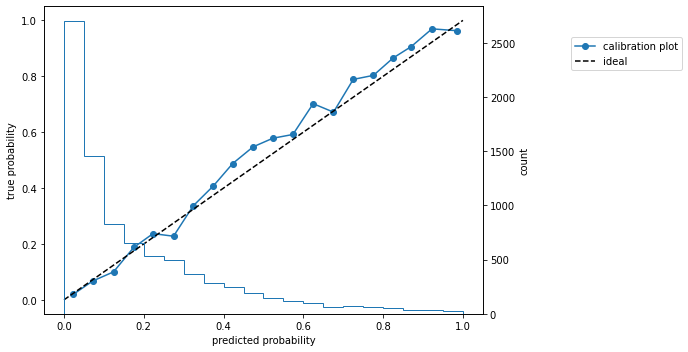

In [29]:
rs = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary')
model.fit(X_train, y_train)
lgb_pred = model.predict_proba(X_test)[:, 1]

# LightGBM: 補正前のcalibration curve
# print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=lgb_pred)))
# calibration_plot(y_true=y_test, y_prob=lgb_pred)

# LightGBM: 補正後のcalibration curve
lgb_calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=5)
lgb_calibrated_model.fit(X_train, y_train)
lgb_calibrated_pred = lgb_calibrated_model.predict_proba(X_test)[:, 1]
print(lgb_calibrated_model.score(X_test, y_test))
print('AUC = {:.3f}'.format(roc_auc_score(y_true=y_test, y_score=lgb_calibrated_pred)))
calibration_plot(y_true=y_test, y_prob=lgb_calibrated_pred)

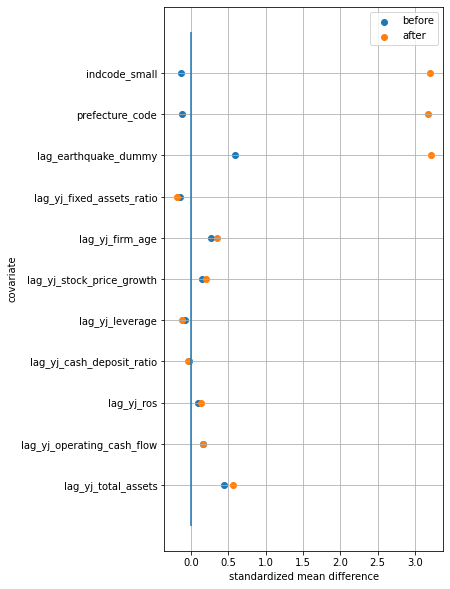

In [14]:
def standardized_mean_difference(X1, X0): # SMDを計算する関数
    N1 = len(X1)
    N0 = len(X0)
    s_pool = ((N1-1)*np.var(X1)+(N0-1)*np.var(X0))/(N1+N0-2)

    return (np.mean(X1)-np.mean(X0))/np.sqrt(s_pool)

def smd_on_the_treated(X, Z, ps): # 傾向スコアを用いた調整前後のSMDを計算する関数
    X1 = X[Z==1]
    X0 = X[Z==0]
    ps0 = ps[Z==0]
    X10 = X0*ps0/(1-ps0)

    smd_before = standardized_mean_difference(X1, X0)
    smd_after = standardized_mean_difference(X1, X10)

    return smd_before, smd_after

# 各共変量について、傾向スコアを用いた調整前後のSMDを計算する
smd_list = []
for name in X.columns:
    smd_before, smd_after = smd_on_the_treated(X=X[name], Z=y, ps=ps)
    smd_list.append([name, smd_before, smd_after])
smd_df = pd.DataFrame(smd_list, columns=['covariate', 'SMD(before)', 'SMD(after)'])

# 各共変量について、傾向スコアを用いた調整前後のSMDをプロットする（love plotを作成する）
plt.figure(figsize=(5, 10))
plt.scatter(smd_df['SMD(before)'], smd_df['covariate'], label='before')
plt.scatter(smd_df['SMD(after)'], smd_df['covariate'], label='after')
plt.vlines([0], ymin=-1, ymax=X.shape[1])
plt.legend()
plt.xlabel('standardized mean difference')
plt.ylabel('covariate')
plt.grid(True)
plt.show()

In [4]:
df.columns

Index(['stock_code', 'firm_name', 'year', 'month', 'establishment',
       'prefecture', 'indname_small', 'indname_large', 'yj_sales_growth',
       'yj_total_assets', 'yj_operating_cash_flow', 'yj_ros',
       'yj_cash_deposit_ratio', 'yj_leverage', 'yj_stock_price_growth',
       'yj_net_profit_growth', 'yj_firm_age', 'yj_fixed_assets_ratio',
       'yj_earthquake_dummy', 'lag_yj_sales_growth', 'lag_yj_total_assets',
       'lag_yj_operating_cash_flow', 'lag_yj_ros', 'lag_yj_cash_deposit_ratio',
       'lag_yj_leverage', 'lag_yj_stock_price_growth',
       'lag_yj_net_profit_growth', 'lag_yj_firm_age',
       'lag_yj_fixed_assets_ratio', 'lag_yj_earthquake_dummy',
       'earthquake_dummy', 'lag_earthquake_dummy', 'BCP'],
      dtype='object')